## Общее описание:
Вы работаете аналитиком в приложении для онлайн-знакомств. Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Ваша задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать одну или несколько метрик, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.


### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Построим графики
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было
    - Какие действия нужно предпринять разработчикам/бизнесу, чтобы стало лучше? Как можно будет позже провести A/B тестирование? (починить android приложение, возможно таргетить и мотивировать не очень активных водителей, улучшить программу лояльности и бонусов для водителей и тд и тп)


## 1: загружаем данные и просматриваем данные

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pingouin as pg

In [4]:
sns.set(rc={'figure.figsize':(19, 7), 'axes.titlesize':16, 'axes.labelsize':14, 'xtick.labelsize':12, 
            'ytick.labelsize':12,'axes.titlepad': 30, # 'font.family': 'Roboto' 
           })

In [5]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-se-vlasov/math_stat/Lesson10/projects/dating_data.csv')

In [6]:
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [7]:
df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [8]:
df \
    .query('group == 1')['user_id_1'].nunique()

499

In [9]:
df \
    .query('group == 0')['user_id_1'].nunique()

501

## 2: графики, гипотезы и тесты

### Сформулируем гипотезы
-  Количество пар(мэтчей) увеличилось/уменьшилось 
-  Среднее количество действий на одного пользователя (активность) увеличилось/уменьшилось
-  Отношение лайков к общей активности пользователя изменилось

**Проверим первую гипотезу: Количество пар(мэтчей) увеличилось/уменьшилось**

In [10]:
#посчитаем кол-во дейтсвий(мэтч и анмэтч) по групппам
df_cnt_activ = df \
    .groupby('group', as_index=False) \
    .agg({'is_match' : 'count'}) \
    .rename(columns={'is_match' : 'total_activity'})
df_cnt_activ

,group,total_activity
0,0,4792
1,1,9722


In [11]:
#посчитаем кол-во мэтчей по групппам
df_cnt_matches = df \
    .groupby('group', as_index=False) \
    .agg({'is_match' : 'sum'}) \
    .rename(columns={'is_match' : 'total_matches'})
df_cnt_matches

,group,total_matches
0,0,934
1,1,3909


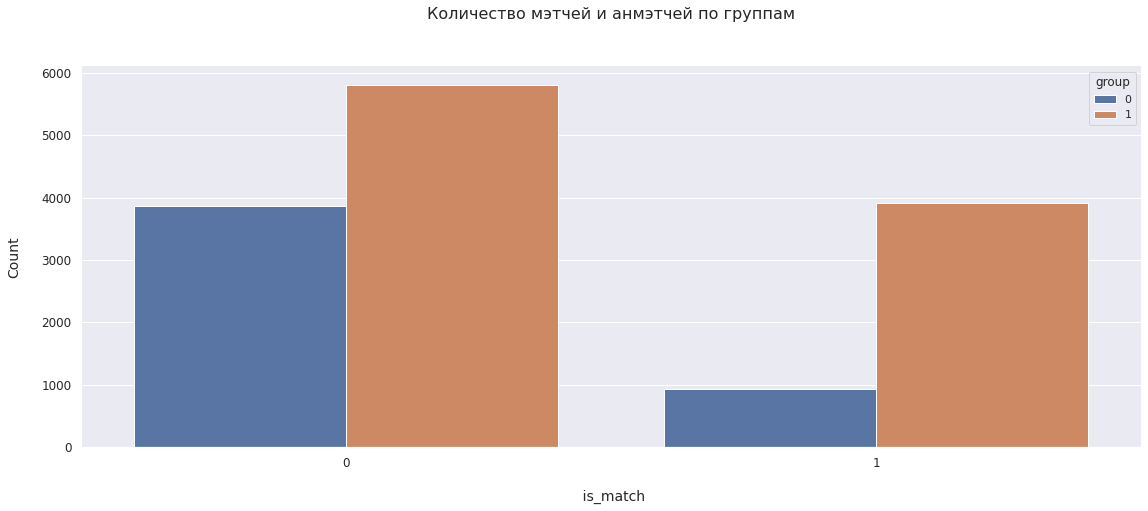

In [12]:
ax = sns.countplot(x=df.is_match, hue=df.group)
ax.set_title('Количество мэтчей и анмэтчей по группам\n') #добавили заголовок 
ax.set_ylabel('Count\n')             #добавили описание оси y
ax.set_xlabel('\n is_match')                       
sns.despine()

In [13]:
#сведем информацию по общему количеству дейтсвий(мэтч и анмэтч) и только мэтч в одну таблицу
df_math_activ = df_cnt_activ.merge(df_cnt_matches, on='group')
df_math_activ

,group,total_activity,total_matches
0,0,4792,934
1,1,9722,3909


In [14]:
#Посмотрим процент мэтчей от общего количества дейтсвий пользователей
df_math_activ['matches_percent'] = df_math_activ['total_matches'] / df_math_activ['total_activity'] * 100
df_math_activ

,group,total_activity,total_matches,matches_percent
0,0,4792,934,19.490818
1,1,9722,3909,40.207776


In [15]:
df_test = df[['group', 'is_match']]
df_test.head()

,group,is_match
0,1,1
1,1,1
2,0,0
3,1,1
4,0,1


In [16]:
#Можем сформировать табоицу сопряженности при помощи crosstab
pd.crosstab(df_test['group'], df_test['is_match'])

is_match,0,1
group,,
0,3858,934
1,5813,3909


In [17]:
#А можем сразу воспользоваться критерием хи-квадрат из библиотеки pingouin
expected, observed, stats = pg.chi2_independence(df_test, x='group',
                                                 y='is_match')

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [18]:
expected

is_match,0,1
group,,
0,3193.015847,1598.984153
1,6477.984153,3244.015847


In [19]:
observed

is_match,0,1
group,,
0,3857.5,934.5
1,5813.5,3908.5


In [20]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


**Интерпритируем результат:**
pval намного меньше 0.05, что позволяет нам отклонить - $H_0$ гипотезу


**Проверим вторую гипотезу: Среднее количество действий на одного пользователя (активность) увеличилось/уменьшилось**

Посмотрим активность на пользователя т.е количество мэтчей и количество анмэтчей 

In [21]:
df_users_activ = df \
    .groupby(['group','user_id_1'], as_index=False) \
    .agg({'user_id_2' : 'count'}) \
    .rename(columns={'user_id_2' : 'activity_cnt'}) 
df_users_activ

,group,user_id_1,activity_cnt
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20
...,...,...,...
995,1,987,23
996,1,992,21
997,1,993,18
998,1,998,18


Посмотрим распределение активности пользователей в разных группах:

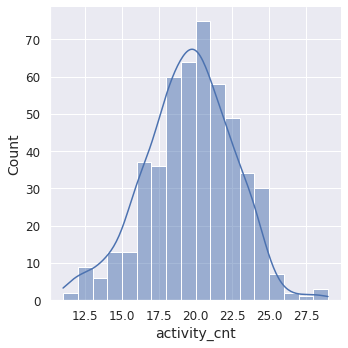

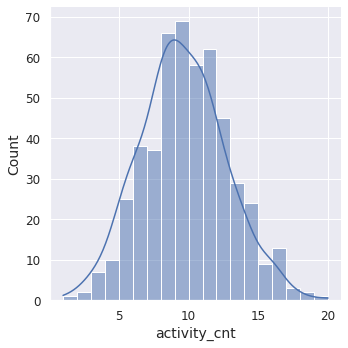

In [22]:
sns.displot(data=df_users_activ.query('group == 1'), x='activity_cnt', kde=True)
sns.displot(data=df_users_activ.query('group == 0'), x='activity_cnt', kde=True)

In [23]:
#проверим нашу величину на нормальность
pg.normality(data=df_users_activ, dv="activity_cnt", group="group", method="normaltest")

,W,pval,normal
0,2.406168,0.300267,True
1,4.262189,0.118707,True


In [24]:
df_users_activ_group = df_users_activ \
    .groupby('group', as_index=False) \
    .agg({'activity_cnt' : 'mean'})
df_users_activ_group 

,group,activity_cnt
0,0,9.564870
1,1,19.482966


In [25]:
#Проведем t-test
pg.ttest(df_users_activ.query('group == 1')['activity_cnt'], df_users_activ.query('group == 0')['activity_cnt'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,51.85607,997.694538,two-sided,2.005369e-285,"[9.54, 10.29]",3.279531,9.827e+280,1.0


pval сильно меньше 0.05, что позволяет нам отклонить нулевую гипотезу
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

**Проверим тертью гипотезу: Отношение лайков к общей активности пользователя изменилось**

In [26]:
#еще раз посмотрим на активность каждого пользователя
df_total_activity_user = df \
    .groupby(['user_id_1', 'group'], as_index=False) \
    .agg({'is_match' : 'count'})
df_total_activity_user

,user_id_1,group,is_match
0,1,1,24
1,2,1,16
2,3,1,16
3,4,0,9
4,5,1,22
...,...,...,...
995,996,0,8
996,997,0,12
997,998,1,18
998,999,0,7


In [27]:
#посчитаем количество мэтчей на пользователя 
df_total_match_user = df \
    .groupby(['user_id_1', 'group'], as_index=False) \
    .agg({'is_match' : 'sum'})
df_total_match_user

,user_id_1,group,is_match
0,1,1,11
1,2,1,7
2,3,1,5
3,4,0,2
4,5,1,13
...,...,...,...
995,996,0,1
996,997,0,1
997,998,1,10
998,999,0,2


In [28]:
#собираем общую таблицу
test = df_total_activity_user.merge(df_total_match_user[['is_match', 'user_id_1']], on='user_id_1', suffixes=('_activity', '_total'))
test

,user_id_1,group,is_match_activity,is_match_total
0,1,1,24,11
1,2,1,16,7
2,3,1,16,5
3,4,0,9,2
4,5,1,22,13
...,...,...,...,...
995,996,0,8,1
996,997,0,12,1
997,998,1,18,10
998,999,0,7,2


In [37]:
#считаем отношение мэтчей к общему количеству дейтсвий на пользователя
test['match_per_total_activity'] = test['is_match_total'] / test['is_match_activity']
test

,user_id_1,group,is_match_activity,is_match_total,match_per_total_activity
0,1,1,24,11,0.458333
1,2,1,16,7,0.437500
2,3,1,16,5,0.312500
3,4,0,9,2,0.222222
4,5,1,22,13,0.590909
...,...,...,...,...,...
995,996,0,8,1,0.125000
996,997,0,12,1,0.083333
997,998,1,18,10,0.555556
998,999,0,7,2,0.285714


In [38]:
test \
    .groupby('group', as_index=False) \
    .agg({'match_per_total_activity' : 'mean'})

,group,match_per_total_activity
0,0,0.194099
1,1,0.402345


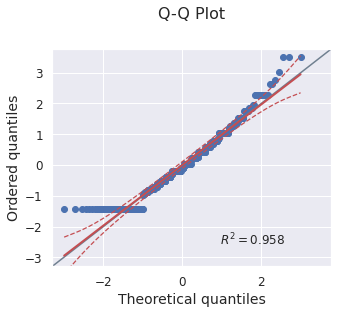

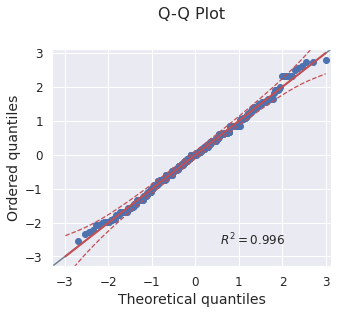

In [53]:
pg.qqplot(test.query('group == 0')['match_per_total_activity'])
pg.qqplot(test.query('group == 1')['match_per_total_activity'])

In [54]:
#проверим величину на нормальность
pg.normality(data=test, dv="match_per_total_activity", group="group", method="normaltest")

,W,pval,normal
1,0.273892,0.872017,True
0,24.051422,0.000006,False


In [55]:
#Применим U-тест Манна-Уитни
pg.mwu(test.query('group == 0')['match_per_total_activity'],test.query('group == 1')['match_per_total_activity'])

,U-val,alternative,p-val,RBC,CLES
MWU,29762.0,two-sided,1.073929e-96,0.761903,0.119048


pval < 0.05 поэтому нулевую гипотезу мы отклоняем
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

**Итоги:**

Был проведен эксперимент в котором учавствовало две группы:

In [35]:
print(f'Первая группа со старым алгоритмом: {df.query("group == 0")["user_id_1"].nunique()} пользователь\nВторая группа c новым алгоритмом: \
{df.query("group == 1")["user_id_1"].nunique()} пользователей')

Первая группа со старым алгоритмом: 501 пользователь
Вторая группа c новым алгоритмом: 499 пользователей


Исследуя гипотезы, мы получили следующие резульаты :
-  Количество пар(мэтчей) увеличилось/уменьшилось: **статистически значимо изменилось**
-  Среднее количество действий на одного пользователя (активность) увеличилось/уменьшилось **статистически значимо изменилось**
-  Отношение лайков к общей активности пользователя изменилось: **Статистически изменилось**

Количество пар(мэтчей) увеличилось более чем в 4 раза</br>
Среднее количество действий на одного пользователя(активность) увеличилось более чем в 2 раза</br>
Отношение лайков к общей активности пользователя изменилось более чем в 2 раза</br>

По всем исследуемым метрикам мы поличили статистически значимые изменения. Стоит оценить затраты на внедрение такого алгоритма и боль осуществить ошибку первого или второго рода. А так же понять какой был ожидаемый эффект от проведения А/В теста. Если нас устраивает полученный эффект и стоимость внедрения такого алгоритма, то его можно применить ко всем пользователям